## Модули

In [1]:
import keras
from keras.datasets import cifar10
from keras.layers import (
    Conv2D,
    BatchNormalization,
    MaxPooling2D,
    Dropout,
    Flatten,
    Dense,
)
import keras_tuner as kt

import cv2
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report

## Загрузка данных

Загрузим датасет CIFAR10.

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [3]:
print("Параметры обучающего набора данных:")
print(f"X_train.shape = {X_train.shape}")
print(f"y_train.shape = {y_train.shape}")
print(f"X_train.dtype = {X_train.dtype}")
print(f"y_train.dtype = {y_train.dtype}\n")

print("Параметры тестового набора данных:")
print(f"X_test.shape = {X_test.shape}")
print(f"y_test.shape = {y_test.shape}")
print(f"X_test.dtype = {X_test.dtype}")
print(f"y_test.dtype = {y_test.dtype}")

Параметры обучающего набора данных:
X_train.shape = (50000, 32, 32, 3)
y_train.shape = (50000, 1)
X_train.dtype = uint8
y_train.dtype = uint8

Параметры тестового набора данных:
X_test.shape = (10000, 32, 32, 3)
y_test.shape = (10000, 1)
X_test.dtype = uint8
y_test.dtype = uint8


Изменим форму массивов, содержащих метки, для удобства использования.

In [4]:
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

print(f"y_train.shape = {y_train.shape}")
print(f"y_test.shape = {y_test.shape}")

y_train.shape = (50000,)
y_test.shape = (10000,)


In [5]:
print(f"Классы обучающего набора данных: {np.unique(y_train)}")
print(
    f"Количество элементов каждого класса в обучающем наборе {np.unique(y_train, return_counts=True)[1]}\n"
)

print(f"Классы тестового набора данных: {np.unique(y_test)}")
print(
    f"Количество элементов каждого класса в тестовом наборе {np.unique(y_test, return_counts=True)[1]}"
)

Классы обучающего набора данных: [0 1 2 3 4 5 6 7 8 9]
Количество элементов каждого класса в обучающем наборе [5000 5000 5000 5000 5000 5000 5000 5000 5000 5000]

Классы тестового набора данных: [0 1 2 3 4 5 6 7 8 9]
Количество элементов каждого класса в тестовом наборе [1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]


In [6]:
label_description = {
    0: "Airplane",
    1: "Automobile",
    2: "Bird",
    3: "Cat",
    4: "Deer",
    5: "Dog",
    6: "Frog",
    7: "Horse",
    8: "Ship",
    9: "Truck",
}

print(f"Расшифровка меток классов: {label_description}")

Расшифровка меток классов: {0: 'Airplane', 1: 'Automobile', 2: 'Bird', 3: 'Cat', 4: 'Deer', 5: 'Dog', 6: 'Frog', 7: 'Horse', 8: 'Ship', 9: 'Truck'}


Можно видеть, что набор данных состоит из числовых значений, содержит 10 различных классов и является сбалансированным. Поскольку датасет сбалансирован, то для оценки качества классификации можно использовать метрику Accuracy.

In [7]:
print(
    f"Наличие дубликатов в X_train: {(np.unique(X_train, return_counts=True, axis=0)[1] > 1).any()}"
)
print(
    f"Наличие дубликатов в X_test: {(np.unique(X_test, return_counts=True, axis=0)[1] > 1).any()}"
)

Наличие дубликатов в X_train: False
Наличие дубликатов в X_test: False


In [8]:
print(f"Наличие пропусков в X_train: {np.isin(X_train, [None, np.nan]).any()}")
print(f"Наличие пропусков в y_train: {np.isin(y_train, [None, np.nan]).any()}\n")

print(f"Наличие пропусков в X_test: {np.isin(X_test, [None, np.nan]).any()}")
print(f"Наличие пропусков в y_test: {np.isin(y_test, [None, np.nan]).any()}")

Наличие пропусков в X_train: False
Наличие пропусков в y_train: False

Наличие пропусков в X_test: False
Наличие пропусков в y_test: False


В наборе данных отсутствуют дубликаты и пропуски.

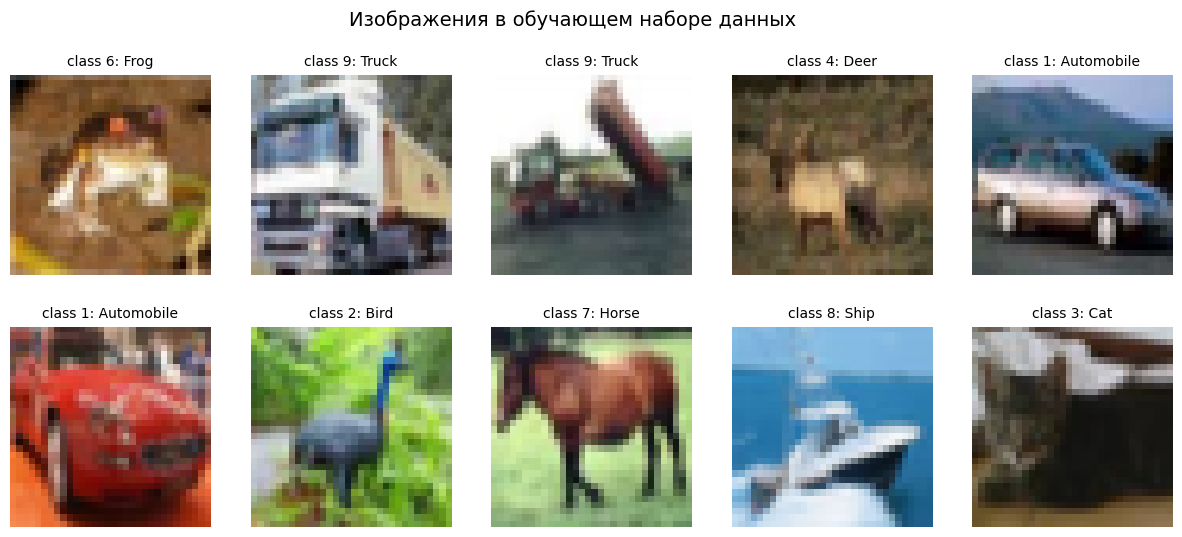

In [9]:
# Отрисовка первых десяти примеров с метками классов
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
fig.suptitle("Изображения в обучающем наборе данных", fontsize=14)
for idx, (i, j) in zip(range(10), [(i, j) for i in range(2) for j in range(5)]):
    axs[i, j].imshow(X_train[idx], cmap="binary")
    axs[i, j].set_title(
        f"class {y_train[idx]}: {label_description[y_train[idx]]}", fontsize=10
    )
    axs[i, j].axis("off")

In [10]:
# Приведем данные к масштабу [0, 1] для использования в качестве входных данных нейронной сети
X_train = X_train.astype("float32") / X_train.max()
X_test = X_test.astype("float32") / X_test.max()

print(f"Диапазон значений X_train: {X_train.min()} - {X_train.max()}")
print(f"Диапазон значений X_test: {X_test.min()} - {X_test.max()}")

Диапазон значений X_train: 0.0 - 1.0
Диапазон значений X_test: 0.0 - 1.0


## Определение оптимальной архитектуры

Рассмотрим 3 различных архитектуры сверточных нейронных сетей: с использованием Dropout, с использованием BatchNormalization, а также с одновременным использованием Dropout и BatchNormalization. Каждая из них будет состоять из 3 последовательных блоков сверточных слоев, а также полносвязанных слоев. Для поиска гиперпараметров, дающих максимальное значение Accuracy на тестовой выборке, будем использовать keras_tuner.

In [11]:
INPUT_SHAPE = X_train.shape[1:]
N_CLASSES = np.unique(y_train).shape[0]
BATCH_SIZE = 256

In [12]:
def model_builder(hp):
    model = keras.Sequential()
    model.add(keras.Input(shape=INPUT_SHAPE))

    model_type = hp.Choice("CNNType", ["CNN1", "CNN2", "CNN3"])
    activation = hp.Choice("activation", ["relu", "tanh", "sigmoid"])
    kernel_size = hp.Choice("kernel_size", values=[3, 5])
    filters = [
        hp.Int("conv_block1_filters", 32, 64, step=2, sampling="log"),
        hp.Int("conv_block2_filters", 64, 128, step=2, sampling="log"),
        hp.Int("conv_block3_filters", 128, 256, step=2, sampling="log"),
    ]

    # CNNType1: Dropout
    with hp.conditional_scope("CNNType", ["CNN1"]):
        if model_type == "CNN1":
            for i in range(3):
                model.add(
                    Conv2D(
                        filters[i], kernel_size, padding="same", activation=activation
                    )
                )
                model.add(
                    Conv2D(
                        filters[i], kernel_size, padding="same", activation=activation
                    )
                )
                model.add(MaxPooling2D((2, 2), strides=2))
                model.add(Dropout(hp.Float("dropout_rate_CNN1", 0.2, 0.8, step=0.2)))

    # CNNType2: BatchNormalization
    with hp.conditional_scope("CNNType", ["CNN2"]):
        if model_type == "CNN2":
            for i in range(3):
                model.add(
                    Conv2D(
                        filters[i], kernel_size, padding="same", activation=activation
                    )
                )
                model.add(
                    Conv2D(
                        filters[i], kernel_size, padding="same", activation=activation
                    )
                )
                model.add(BatchNormalization())
                model.add(MaxPooling2D((2, 2), strides=2))

    # CNNType3: Dropout + BatchNormalization
    with hp.conditional_scope("CNNType", ["CNN3"]):
        if model_type == "CNN3":
            for i in range(3):
                model.add(
                    Conv2D(
                        filters[i], kernel_size, padding="same", activation=activation
                    )
                )
                model.add(
                    Conv2D(
                        filters[i], kernel_size, padding="same", activation=activation
                    )
                )
                model.add(BatchNormalization())
                model.add(MaxPooling2D((2, 2), strides=2))
                model.add(Dropout(hp.Float("dropout_rate_CNN3", 0.2, 0.8, step=0.2)))

    model.add(Flatten())
    model.add(
        Dense(
            hp.Int("dense_units", 64, 256, step=2, sampling="log"),
            activation=activation,
        )
    )
    model.add(Dropout(hp.Float("dropout_rate_dense", 0.2, 0.8, step=0.2)))
    model.add(Dense(N_CLASSES, activation="softmax"))

    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Float("learning_rate", 1e-4, 1e-3, step=10, sampling="log")
        ),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model

In [13]:
tuner = kt.RandomSearch(
    hypermodel=model_builder,
    objective="val_accuracy",
    max_trials=5,
    directory="./keras_tuner",
    project_name="cifar10_classification",
    overwrite=False,
)

tuner.search(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=BATCH_SIZE,
    epochs=30,
    callbacks=[keras.callbacks.EarlyStopping(patience=7)],
)

Reloading Tuner from ./keras_tuner\cifar10_classification\tuner0.json


Ниже можно видеть параметры keras_tuner и архитектуру нейронной сети, с помощью которых удалось достичь максимального значения метрики Accuracy.

In [14]:
tuner.get_best_hyperparameters(1)[0].values

{'CNNType': 'CNN3',
 'activation': 'relu',
 'kernel_size': 3,
 'conv_block1_filters': 32,
 'conv_block2_filters': 64,
 'conv_block3_filters': 256,
 'dense_units': 64,
 'dropout_rate_dense': 0.4,
 'learning_rate': 0.001,
 'dropout_rate_CNN3': 0.2}

In [15]:
best_model = tuner.get_best_models(1)[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        1

In [16]:
print(f"test_accuracy after keras_tuner: {best_model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)[1]:.2f}")

40/40 [==============================] - 3s 9ms/step - loss: 0.5574 - accuracy: 0.8357
test_accuracy after keras_tuner: 0.84


Наибольшая величина метрики достигнута с помощью модели сверточной нейронной сети, содержащей одновременно слои BatchNormalization и Dropout.

## Обучение модели

Обучим модель, с найденной архитектурой, при большем количестве эпох, сохраним модель, с максимальным значением Accuracy на тестовом наборе, с помощью callbaks.

In [17]:
best_hps = tuner.get_best_hyperparameters(1)[0]
model = tuner.hypermodel.build(best_hps)

history_model = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=BATCH_SIZE,
    epochs=50,
    callbacks=[
        keras.callbacks.ModelCheckpoint(
            "./cifar10_model.h5",
            monitor="val_accuracy",
            save_best_only=True,
            verbose=1,
        )
    ],
)

Epoch 1/50
196/196 [==============================] - ETA: 0s - loss: 1.9973 - accuracy: 0.2656
Epoch 1: val_accuracy improved from -inf to 0.14740, saving model to .\cifar10_model.h5
196/196 [==============================] - 7s 27ms/step - loss: 1.9973 - accuracy: 0.2656 - val_loss: 3.0843 - val_accuracy: 0.1474
Epoch 2/50
195/196 [============================>.] - ETA: 0s - loss: 1.6110 - accuracy: 0.3894
Epoch 2: val_accuracy improved from 0.14740 to 0.28760, saving model to .\cifar10_model.h5
196/196 [==============================] - 5s 24ms/step - loss: 1.6107 - accuracy: 0.3895 - val_loss: 2.1229 - val_accuracy: 0.2876
Epoch 3/50
195/196 [============================>.] - ETA: 0s - loss: 1.3850 - accuracy: 0.4885
Epoch 3: val_accuracy improved from 0.28760 to 0.56630, saving model to .\cifar10_model.h5
196/196 [==============================] - 5s 24ms/step - loss: 1.3850 - accuracy: 0.4885 - val_loss: 1.2365 - val_accuracy: 0.5663
Epoch 4/50
194/196 [==========================

In [18]:
# Отображение истории обучения
def show_history(history_obj, comment_txt, accuracy_target):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
    fig.suptitle(f"{comment_txt}")

    axs[0].plot(history_obj.history["accuracy"])
    axs[0].plot(history_obj.history["val_accuracy"])
    axs[0].hlines(
        accuracy_target,
        0,
        len(history_model.history["val_accuracy"]),
        color="r",
        ls="--",
    )
    # Отметка максимума val_accuracy стрелкой
    max_acc = max(history_obj.history["val_accuracy"])
    epoch = np.argmax(history_obj.history["val_accuracy"])
    axs[0].annotate(
        f"max_accuracy = {max_acc:.2f}, Epoch {epoch + 1}/{len(history_model.history['val_accuracy'])}",
        xy=(epoch, max_acc),
        xytext=(epoch - epoch // 2, max_acc - max_acc / 4),
        arrowprops={"color": "r", "arrowstyle": "->"},
    )
    axs[0].set_title("Model Accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].set_xlabel("Epoch")
    axs[0].legend(["train", "test", "accuracy target"], loc="lower right")

    axs[1].plot(history_obj.history["loss"])
    axs[1].plot(history_obj.history["val_loss"])
    axs[1].set_title("Model Loss")
    axs[1].set_ylabel("Loss")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(["train", "test"], loc="upper right")

    plt.show()

Отобразим историю обучения модели.

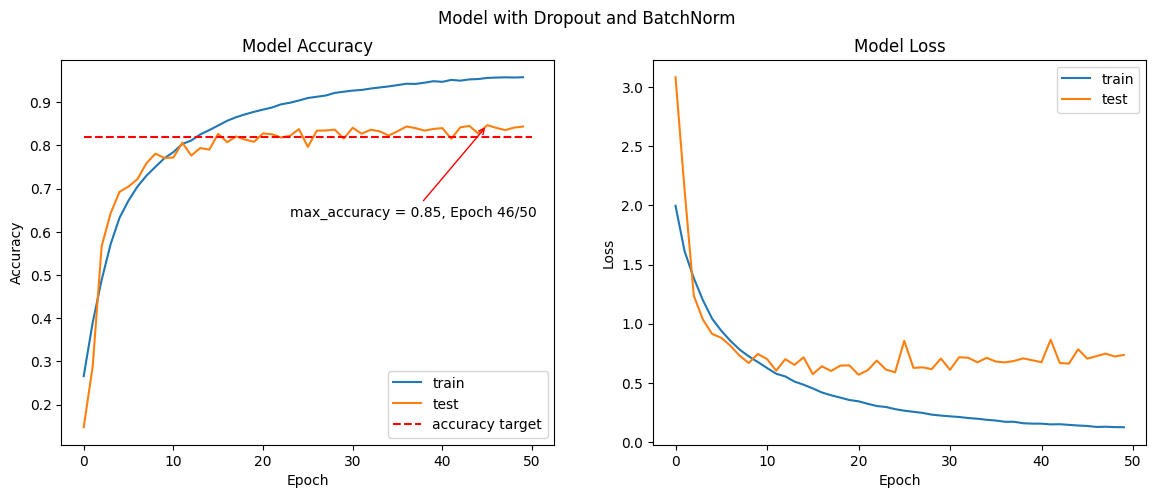

In [19]:
show_history(history_model, "Model with Dropout and BatchNorm", 0.82)

In [20]:
model = keras.models.load_model("./cifar10_model.h5")
print(f"test_accuracy = {model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)[1]:.2f}")

40/40 [==============================] - 0s 8ms/step - loss: 0.7043 - accuracy: 0.8468
test_accuracy = 0.85


Полученное значение метрики выше 82%, что удовлетворяет условию задачи.

## Метрики классификации

In [21]:
def show_report(test_labels, test_preds, classes_names):
    # Построение матрицы ошибок
    cm = confusion_matrix(test_labels, test_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=classes_names,
        yticklabels=classes_names,
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # Отчет о классификации
    print(f"Classification Report")
    print(
        classification_report(
            test_labels, test_preds, target_names=classes_names
        )
    )

Отобразим матрицу ошибок и отчет о классификации.

313/313 [==============================] - 1s 2ms/step


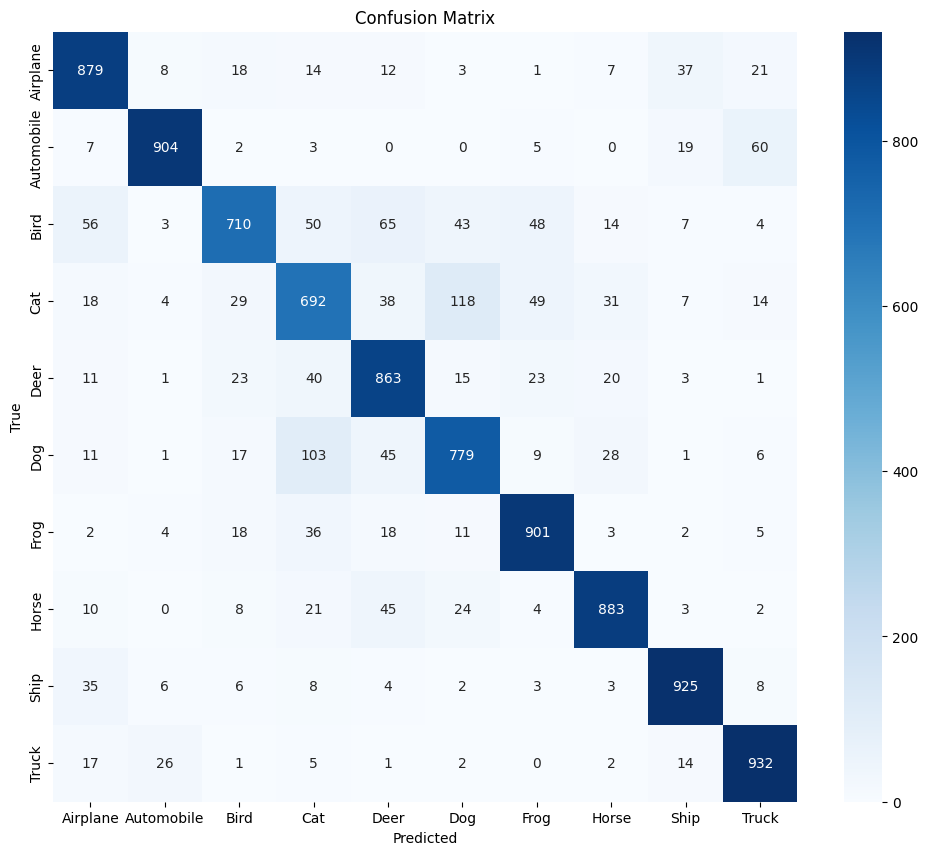

Classification Report
              precision    recall  f1-score   support

    Airplane       0.84      0.88      0.86      1000
  Automobile       0.94      0.90      0.92      1000
        Bird       0.85      0.71      0.78      1000
         Cat       0.71      0.69      0.70      1000
        Deer       0.79      0.86      0.83      1000
         Dog       0.78      0.78      0.78      1000
        Frog       0.86      0.90      0.88      1000
       Horse       0.89      0.88      0.89      1000
        Ship       0.91      0.93      0.92      1000
       Truck       0.89      0.93      0.91      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [22]:
test_preds = np.argmax(model.predict(X_test), axis=-1)
classes_names = [label_description[i] for i in range(N_CLASSES)]
show_report(y_test, test_preds, classes_names)

На рисунке выше можно видеть, что модель классифицирует различные классы с разной точностью, наибольшая точность достигается для классов "Automobile", "Ship", "Truck", а наименьшая для классов "Cat", "Bird", "Dog". Интересно отметить, что модель с некоторой вероятностью путает между собой классы "Cat" и "Dog", а также "Airplane" и "Bird".

## Получение предсказания

Получим метку класса для стороннего изображения из меток CIFAR10.

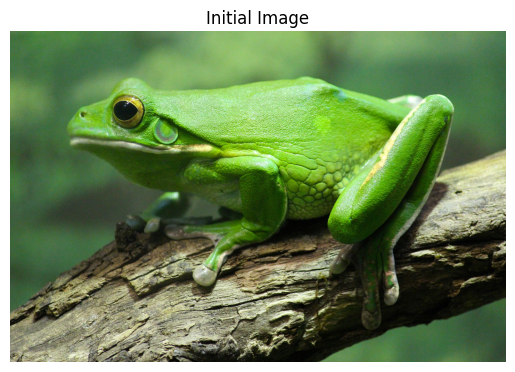

In [23]:
# Загрузка изображения в формате BGR и преобразование BGR -> RGB
image = cv2.imread("./frog.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.title("Initial Image")
plt.axis("off")
plt.show()

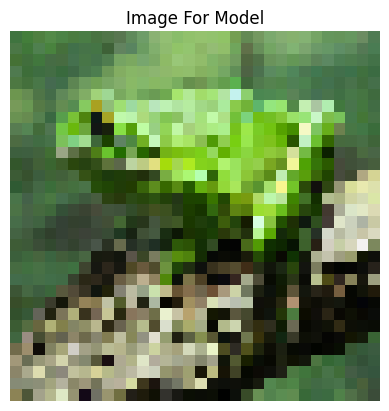

In [24]:
# Изменение размера и нормализация к диапазону [0, 1]
image = cv2.resize(image, (32, 32))
image = image.astype("float32") / image.max()

plt.imshow(image)
plt.title("Image For Model")
plt.axis("off")
plt.show()

In [25]:
prediction = model.predict(np.expand_dims(image, axis=0))
prediction = label_description[np.argmax(prediction)]
prediction

1/1 [==============================] - 0s 80ms/step


'Frog'

Предсказание корректно и соответствует классу изображения.

## Выводы

- Подобраны оптимальные параметры архитектуры с помощью keras_tuner. Наибольшее значение метрики достигнуто с помощью сверточной нейросети, содержащей 3 последовательных блока из сверток, батчнормализации, макспулинга и дропаута, а также полносвязанных слоев.
- Достигнута величина метрики Accuracy на тестовом наборе, равная 85%.
- Получено корректное предсказание класса для стороннего изображения.
- Можно отметить, что набор данных CIFAR10 сложнее, чем fashion_mnist. Это связано с тем, что изображения являются цветными, содержат больше точек данных и следовательно обладают большим числом деталей, которые должна учитывать модель при классификации.